# 08 안전 운전자 예측
* 대회명
    * [Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction)
        * Predict if a driver will file an insurance claim next year
* 미션 : 보험사에서 제공한 고객 데이터를 활용해 운전자가 보험을 청구할 확률 예측
* 문제 유형 : 이진 분류
* 평가지표 : 정규화된 지니계수
* 사용한 모델 : LightGMB과 XGBoost의 앙상블
* 탐색적 데이터 분석
    * 피처 요약표
    * 결측값 시각화
    * 결측값 처리
* 피처 엔지니어링
    * 창의적 피처 엔지니어링
* 하이퍼 파라미터 최적화 : 베이지안 최적화
## 8.1 경진대회 이해
* 개최 기간 : 2017/09/30~2017/11/30
* 참가팀 : 5,156팀
* 폭표 : 운전자가 보험금을 청구할 확률을 예측
* 특징 : 결측값은 -1로 표기
* 타깃값
    * 0 : 청구하지 않음
    * 1 : 청구함
## 8.2 탐색적 데이터 분석

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 데이터 둘러보기
data_path = '../../data/08_safe_driver/'

train_df = pd.read_csv(data_path+'train.csv', index_col='id')
test_df = pd.read_csv(data_path+'test.csv', index_col='id')
submission_df = pd.read_csv(data_path+'sample_submission.csv', index_col='id')

In [3]:
train_df.shape, test_df.shape

((595212, 58), (892816, 57))

In [4]:
train_df.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
test_df.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,8,1,0,0,1,0,0,0,...,1,1,1,12,0,1,1,0,0,1
1,4,2,5,1,0,0,0,0,1,0,...,2,0,3,10,0,0,1,1,0,1
2,5,1,3,0,0,0,0,0,1,0,...,4,0,2,4,0,0,0,0,0,0
3,0,1,6,0,0,1,0,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,5,1,7,0,0,0,0,0,1,0,...,4,0,0,4,0,1,1,0,0,1


In [6]:
submission_df.head()

,target
id,
0,0.0364
1,0.0364
2,0.0364
3,0.0364
4,0.0364


In [7]:
train_df.info()
# ps_[분류]_[분류별일련번호]_[데이터종류]

<class 'pandas.core.frame.DataFrame'>
Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17_bin 

In [8]:
{c.split('_')[1] for c in train_df.columns if len(c.split('_'))>2}

{'calc', 'car', 'ind', 'reg'}

In [9]:
{c.split('_')[-1] for c in train_df.columns if len(c.split('_'))==4}

{'bin', 'cat'}

In [10]:
# 결측값 시각화
import missingno as msno
train_copy_df = train_df.copy().replace(-1, np.NaN)

<Axes: >

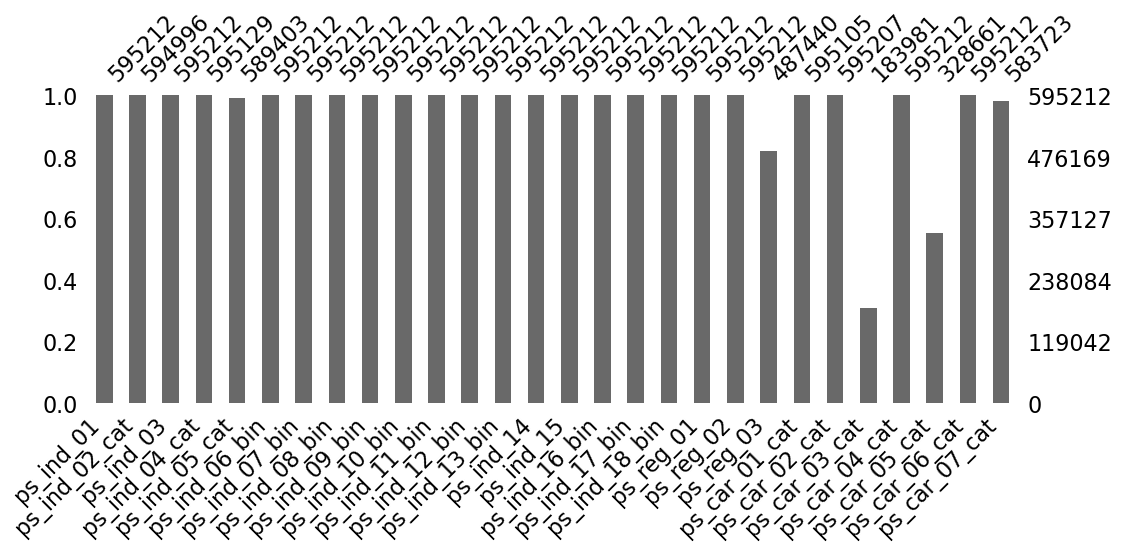

In [11]:
msno.bar(df=train_copy_df.iloc[:, 1:29], figsize=(12,4))

<Axes: >

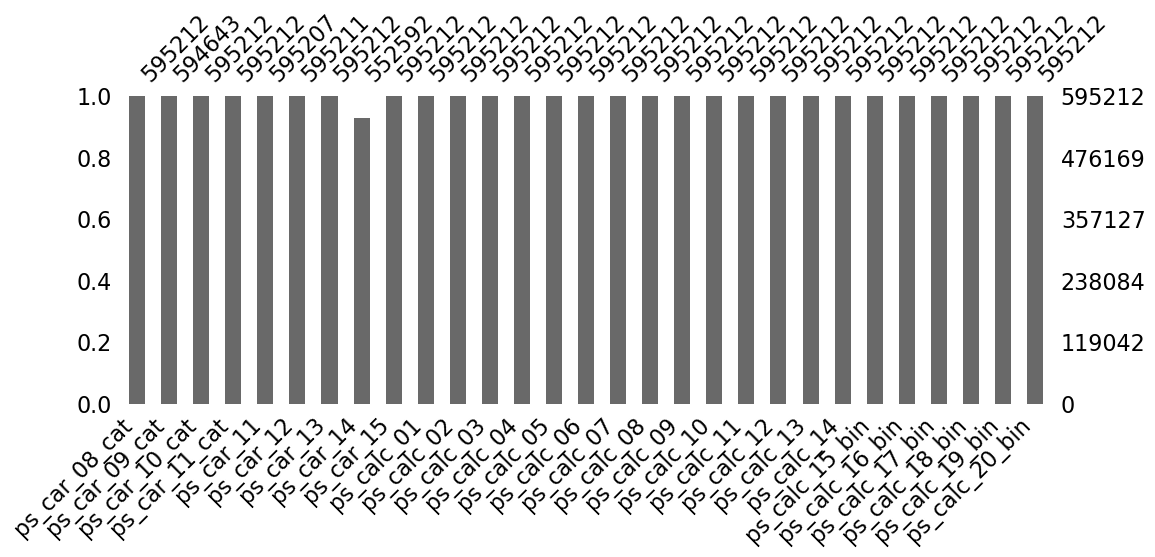

In [12]:
msno.bar(df=train_copy_df.iloc[:, 29:], figsize=(12,4))

In [13]:
# 피처 요약표
def resume_table(df):
    print(f'데이터셋 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary['결측값 개수'] = (df==-1).sum()
    summary['고유값 개수'] = df.nunique()
    summary['데이터 종류'] = None
    for col in df.columns:
        if 'bin' in col or col == 'target':
            summary.loc[col, '데이터 종류'] = '이진형'
        elif 'cat' in col:
            summary.loc[col, '데이터 종류'] = '명목형'
        elif df[col].dtype == np.float64:
            summary.loc[col, '데이터 종류'] = '연속형'
        elif df[col].dtype == np.int64:
            summary.loc[col, '데이터 종류'] = '순서형'

    return summary

In [14]:
# NaN 개수 확인 코드
t = (train_df==-1).sum(axis=0)
t[t>0].sort_values(ascending=False)

ps_car_03_cat    411231
ps_car_05_cat    266551
ps_reg_03        107772
ps_car_14         42620
ps_car_07_cat     11489
ps_ind_05_cat      5809
ps_car_09_cat       569
ps_ind_02_cat       216
ps_car_01_cat       107
ps_ind_04_cat        83
ps_car_02_cat         5
ps_car_11             5
ps_car_12             1
dtype: int64

In [15]:
summary = resume_table(train_df)
summary

데이터셋 형상: (595212, 58)


,데이터 타입,결측값 개수,고유값 개수,데이터 종류
target,int64,0,2,이진형
ps_ind_01,int64,0,8,순서형
ps_ind_02_cat,int64,216,5,명목형
ps_ind_03,int64,0,12,순서형
ps_ind_04_cat,int64,83,3,명목형
ps_ind_05_cat,int64,5809,8,명목형
ps_ind_06_bin,int64,0,2,이진형
ps_ind_07_bin,int64,0,2,이진형
ps_ind_08_bin,int64,0,2,이진형
ps_ind_09_bin,int64,0,2,이진형


In [16]:
# 데이터 시각화
import matplotlib as mpl

In [17]:
# 타깃값 분포
def write_percent(ax, total_size):
    for patch in ax.patches:
        height = patch.get_height()
        width = patch.get_width()
        left_coord = patch.get_x()
        percent = height/total_size*100

        ax.text(
            left_coord+width/2.0,
            height/2.0,
            f'{percent:.1f}%',
            ha='center'
        )

Text(0.5, 1.0, "Target's distribution")

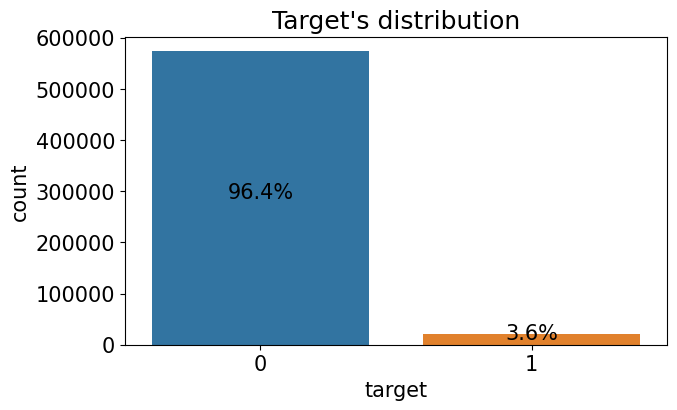

In [18]:
mpl.rc('font', size=15)
plt.figure(figsize=(7,4))

ax = sns.countplot(data=train_df, x='target')
write_percent(ax, len(train_df))
ax.set_title("Target's distribution")

# 각 피처의 고유값별 타깃값 1의 비율 확인
* 신뢰 구간이 좁다면 통계적으로 어느정도 유효
* 고유값 별 1의 비율이 충분히 차이가 나고 신뢰구간도 작은 피쳐 확인
    * 유용한 피처

In [19]:
# 이진 피처
## 이진피처의 고윳값별 타깃값 비율
import matplotlib.gridspec as gridspec

def plot_target_ratio_by_features(df, features, num_rows, num_cols, size=(12,18)):
    mpl.rc('font', size=9)
    plt.figure(figsize=size)
    grid = gridspec.GridSpec(num_rows, num_cols)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        sns.barplot(data=df, x=feature, y='target', palette='Set2', ax=ax)

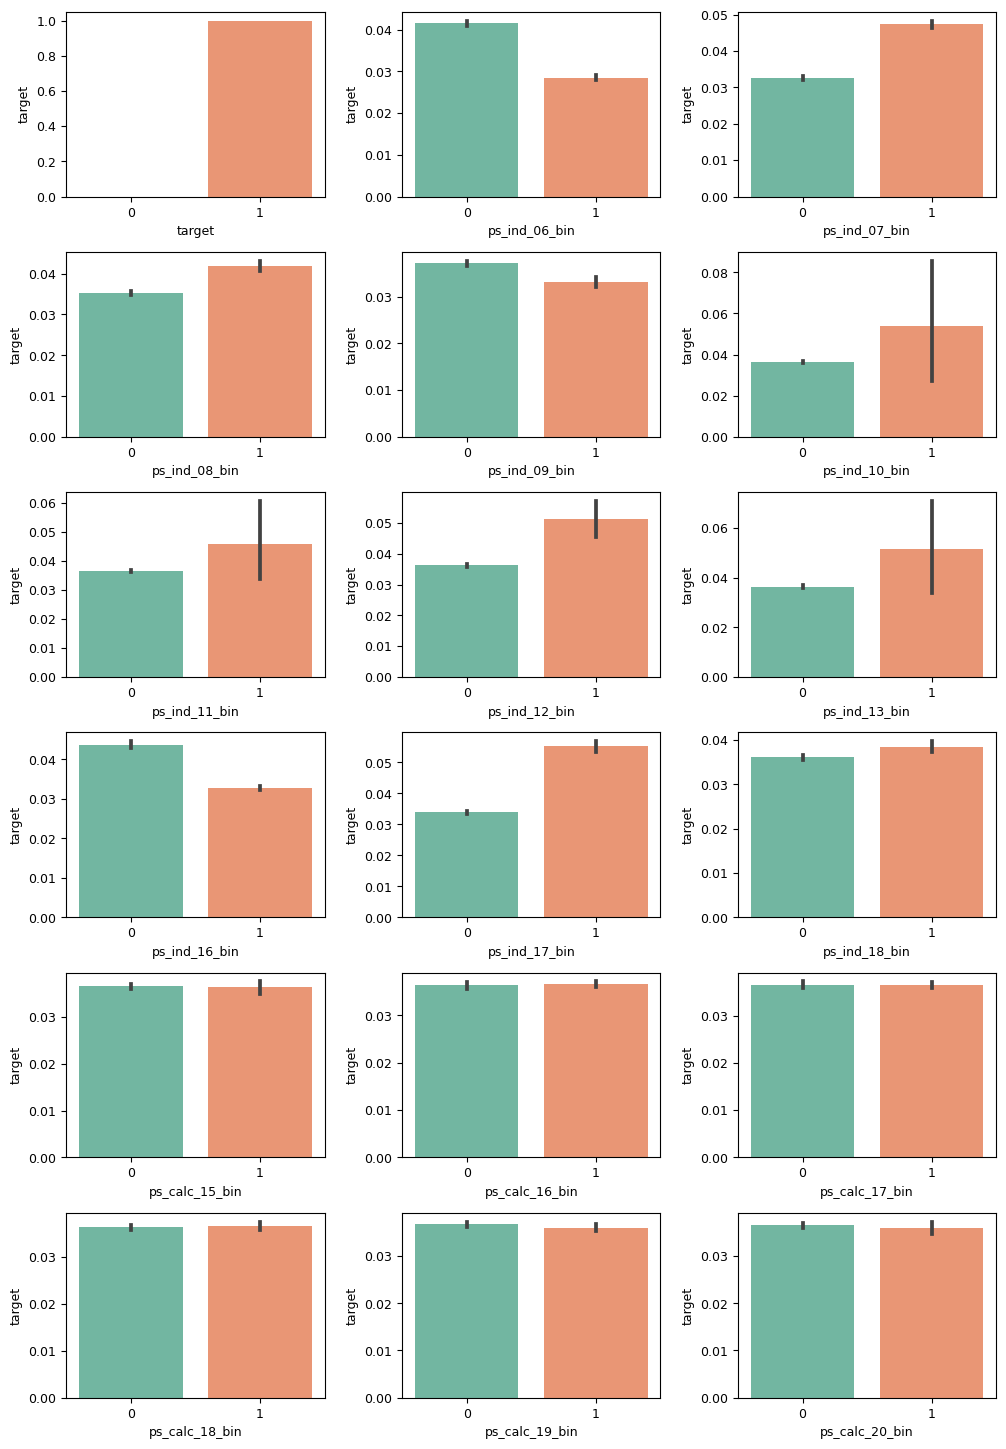

In [20]:
bin_features = summary[summary['데이터 종류']=='이진형'].index
plot_target_ratio_by_features(train_df, bin_features, 6, 3)

### 이진 피처 분석
* 좋은 피처 예시
    * os_ind_06_bin
        * 고유값별 타깃값 비율이 다름
        * 신뢰구간도 좁음
* 나쁜 피처 예시
    * ps_ind_10_bin ~ ps_ind_13_bin
        * 신뢰구간이 넓어 통계적 유효성이 떨어짐
    * ps_calc_15_bin ~ ps_calc_20_bin
        * 고유값별 타깃값 비율 차이가 없어 타깃값 예측력이 없음

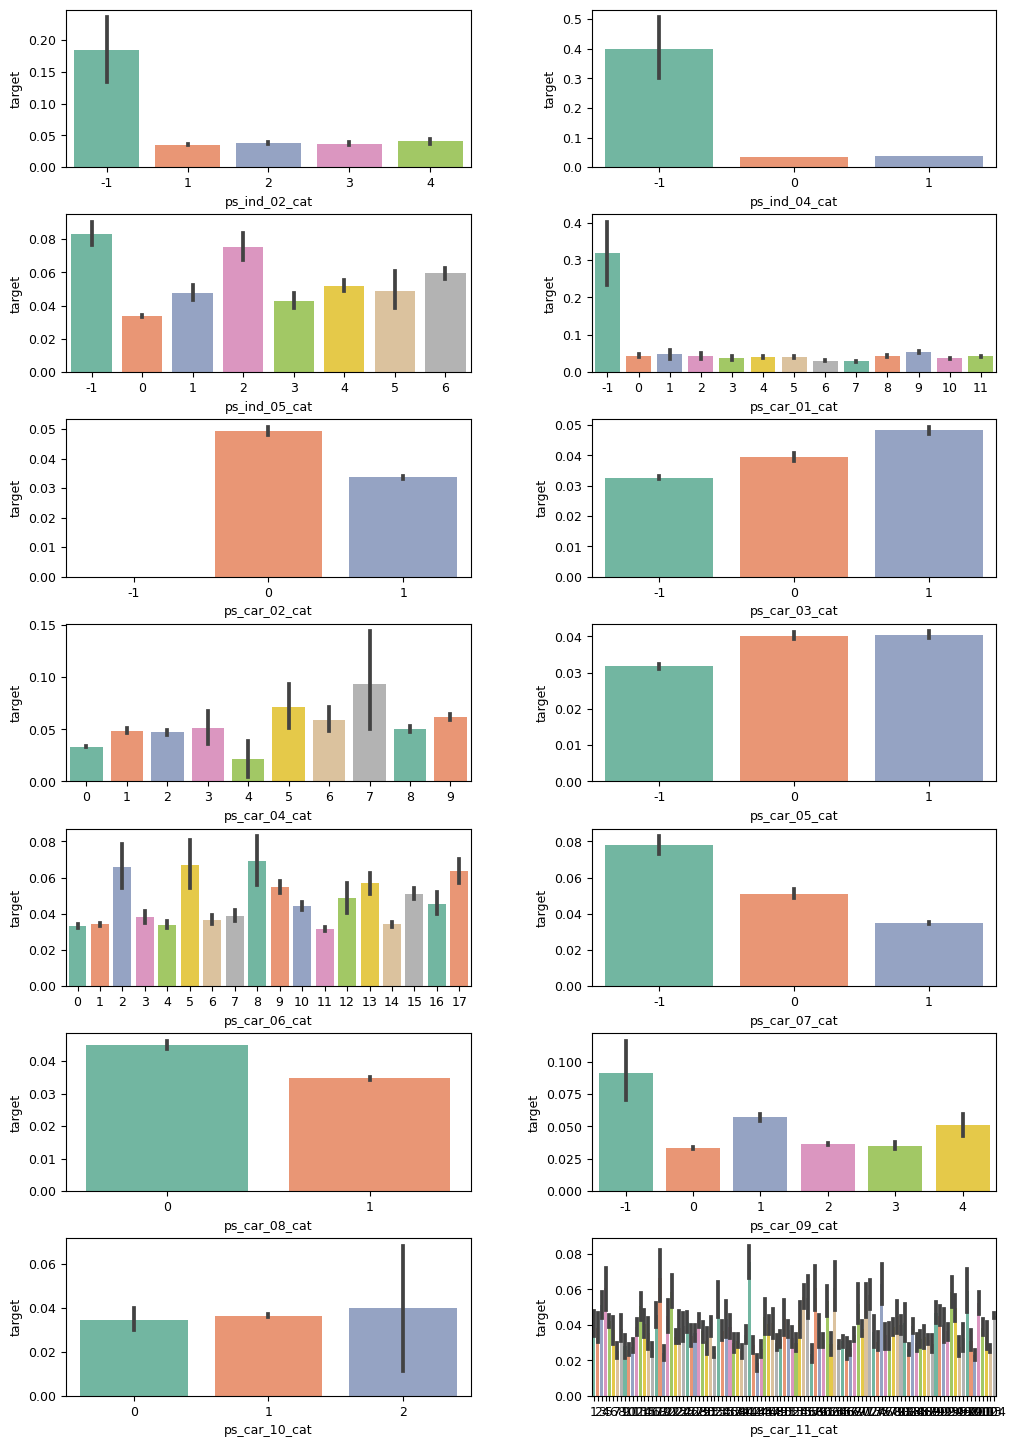

In [21]:
# 명목형 피처
nom_features = summary[summary['데이터 종류']=='명목형'].index
plot_target_ratio_by_features(train_df, nom_features, 7, 2)

### 명목형 피처 분석
* ps_ind_02_cat 피처
    * 결측값 -1이 신뢰구간이 넓다는 점을 감안해도 다른 고유값들보다 타깃값 1의 비율이 큼
    * -1도 하나의 고유값이라 간주
* ps_car_02_cat
    * -1일때 타깃값이 대부분 0이라 판단
* ps_ind_02_cat(위에서 살펴봄), ps_ind_04_cat, ps_car_01_cat
    * 결측값 -1을 제외하고 나머지 고유값은 타깃값 1의 비율 비슷
    * -1의 신뢰하한과 다른 고유값들의 신뢰상한 간 차이가 큼
    * 고유값 간 타깃값 1 비율에 차이가 있으므로 모델링에 필요한 피처라 판단
* ps_car_10_cat
    * 고유값간 1의 평균비율이 비슷
    * 고유값 2의 신뢰구간이 유독 넓음
    * 피처 제거가 애매할 경우 피처를 제거하기 전과 피처를 제거한 후 성능 비교를 하는 것도 하나의 방법
    * 제거하지 않는 편이 성능이 좋았으므로 제거하지 않음

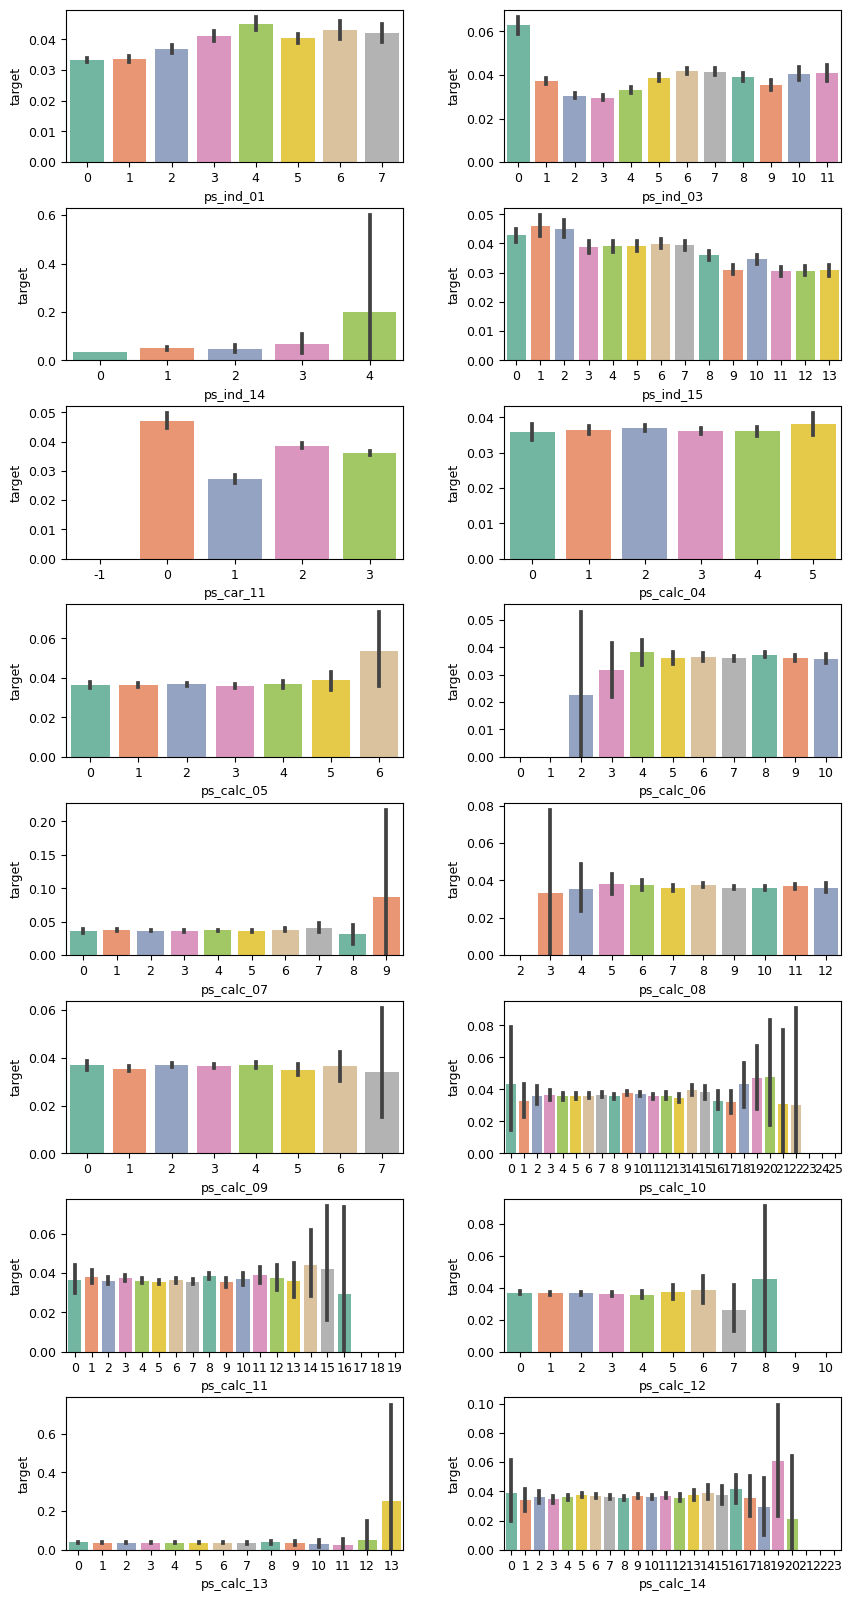

In [22]:
# 순서형 피처
ord_features = summary[summary['데이터 종류'] == '순서형'].index
plot_target_ratio_by_features(train_df, ord_features, 8, 2, (10,20))

### 순서형 피처 분석
* ps_ind_14
    * 타깃값 비율의 신뢰구간이 넓어 통계적 유혀성이 떨어짐
* ps_calc_04 ~ ps_calc_14
    * 고유값별 타깃값 비율 차이가 없음
    * 타깃값 비율이 다르더라도 신뢰구간이 넓어 통계적 유효성이 떨어짐

In [23]:
# 연속형 피처
# pandas cut 함수 테스트 코드
# 연속형 데이터를 범주형 데이터로 바꾸는 효과가 있음
pd.cut([1.0, 1.5, 2.1, 2.7, 3.5, 4.0], 3)

[(0.997, 2.0], (0.997, 2.0], (2.0, 3.0], (2.0, 3.0], (3.0, 4.0], (3.0, 4.0]]
Categories (3, interval[float64, right]): [(0.997, 2.0] < (2.0, 3.0] < (3.0, 4.0]]

In [24]:
pd.cut([1.5, 2.1, 1.0, 2.7, 3.5, 4.0], 3)

[(0.997, 2.0], (2.0, 3.0], (0.997, 2.0], (2.0, 3.0], (3.0, 4.0], (3.0, 4.0]]
Categories (3, interval[float64, right]): [(0.997, 2.0] < (2.0, 3.0] < (3.0, 4.0]]

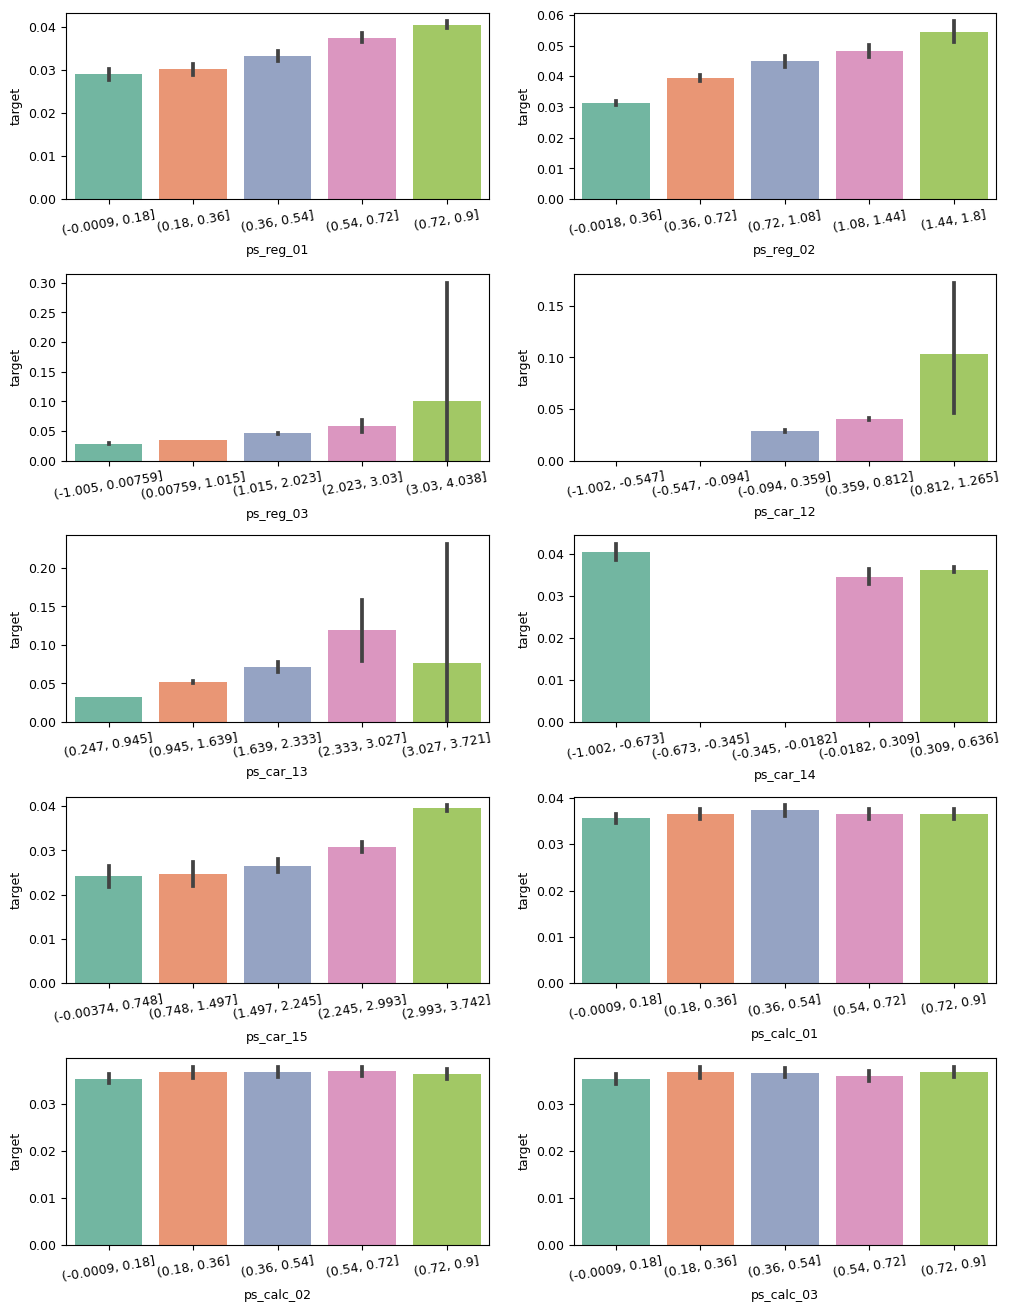

In [25]:
cont_features = summary[summary['데이터 종류'] == '연속형'].index
plt.figure(figsize=(12, 16))
grid = gridspec.GridSpec(5,2)
plt.subplots_adjust(wspace=0.2, hspace=0.4)

for idx, cont_feature in enumerate(cont_features):
    train_df[cont_feature] = pd.cut(train_df[cont_feature], 5)
    ax = plt.subplot(grid[idx])
    sns.barplot(data=train_df, x=cont_feature, y='target', palette='Set2', ax=ax)
    ax.tick_params(axis='x', labelrotation=10)

### 연속형 피처 분석
* ps_calc_01~ps_calc_03
    * 구간별 타깃값 비율 차이가 없음

In [26]:
# 연속형 피처 상관관계 분석
## 0.8 이상의 '아주 강한' 상관관계를 보이는 피처가 있다면 제거를 고려
train_copy_df = train_copy_df.dropna()

<Axes: >

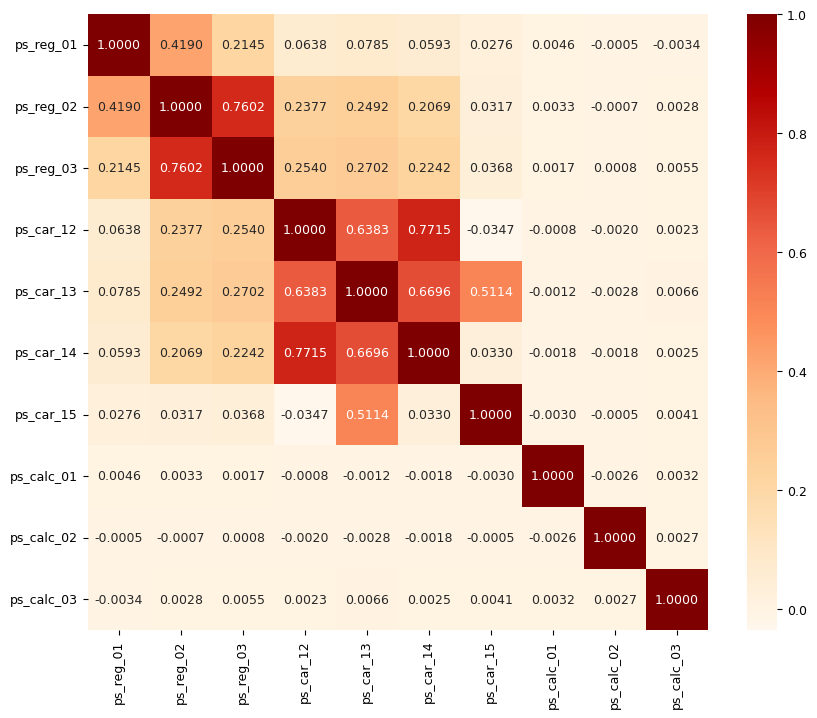

In [27]:
plt.figure(figsize=(10, 8))
cont_corr = train_copy_df[cont_features].corr()
sns.heatmap(cont_corr, annot=True, cmap='OrRd', fmt='.4f')

### 연속형 피처 분석
* ps_car_12 vs ps_car_14
    * 상관관계 : 0.77
    * 제거할 정도로 강한 상관관계는 아니지만 제거 후 테스트 하니 성능이 좋아짐
    * ps_car_14 제거 결정
* ps_reg_02 vs ps_reg_03
    * 상관관계 : 0.76
    * 제거 후 테스트 하니 성능이 떨어짐
    * 두 피처 유지 결정

## 분석 정리 및 모델링 전략
### 분석 정리
* 결측값 처리
    * 결측값 자체에 타깃값 예측력이 있다면 고유값으로 간주
    * 피처 간 상관관계 분석은 결측값 제거 후 수행해야함
* 피처 제거
    * 신뢰 구간이 커서 제거하는 피처
        * ps_ind_14, ps_calc_04 ~ ps_calc_14
    * 구간별 타깃값 차이가 거의 없어 제거하는 피처
        * ps_calc_01 ~ ps_calc_03
    * 강한 상관관계를 보이는 피처 제거
        * ps_car_14

### 모델링 전략
* 베이스라인 모델 : LightGBM
    * 훈련 및 예측 : OOF 예측(과대적합 방지 + 앙상블 효과)
* 성능개선 I
    * 피처 엔지니어링 : 파생 피처 추가
    * 하이퍼파라미터 최적화 : 베이지안 최적화
* 성능 개선 II
    * XGBoost(모델만 변경)
* 성능 개선 III
    * LightGBM + XGBoost 앙상블